# 1 Introduction

Currently, Convolutional and Deep Neural Networks are at the forefront of research in Machine Learning and Computer Science in general. These networks show the best results in solving complex tasks such as Language Processing and Image Generation. On the other hand, in the area of quantum algorithms, scientists are trying to find algorithms and use cases, where quantum computing creates a unique advantage over classical computers. With the current boom of Machine Learning and Neural Networks, one avenue where quantum advantage might be found would be quantum machine learning. In this area, certain aspects of the classical approach are replaced by quantum systems or data. With the currently available quantum computers, one of the most successful approaches uses Variational Quantum Algorithms, as these work fairly well with only a limited amount of qubits and noise. As a result, there has been a lot of work regarding Quantum Machine Learning using Variational Quantum Algorithms. This tutorial will implement one such algorithm. The implementation will solve a classification task and will do so based on the paper by @PerezSalinas2020datareuploading, where the quantum circuit only uses a single qubit and rotational gates to solve the given task. The simulation will be implemented with the Tequila API [@Kottmann_2021] using the qulacs backend for computations. The data and result will be visualized with Matplotlib [@Hunter:2007] and Qutip [@JOHANSSON20131234].

In [1]:
#| output: false

import tequila as tq
import random
import numpy as np
import matplotlib.pyplot as plt
import qutip

# 2 Fundamentals

## Machine Learning

In the most general sense, supervised machine learning aims to train a model using known data to infer knowledge about unknown data based on the training result. In mathematical terms, we are trying to learn some function $M: \mathcal{X} \to \mathcal{Y}$ where $\mathcal{X}$ is the set of all possible data points and $\mathcal{Y}$ is the set of  labels. We do this using only a relatively small set of data points $\{x_i\}\subset \mathcal{X}$ with their labels $\{y_i\}\subset \mathcal{Y}$ and use these to train the parameters $\theta$ of a model $M_\theta(x)$. Through the training we get some optimal parameters $\theta_{opt}$ such that $M_{\theta_{opt}}(x_i)$ is the best approximation of $y_i$. We can then take an unseen data point $x\in\mathcal{X}$ and use our trained model to assign a label ${y}$. We do this by calculating $M_{\theta_{opt}}(x)$ and assigning the result as the label for $x$. One of the most famous examples for this would be the classification of images using a neural network. In that case, the function we are trying to learn maps images to labels. We take a neural network $N_{w,\theta}(x)$ with some tunable weights $w$ and biases $\theta$ and train it using some labeled images. After the training, the neural network should have learned some pattern in the data, and we now can insert a new image, which will return the optimal label based on the training images.

There are many choices which determine the quality of the result. These consist of:

-  The model and its associated parameters
-  The choice of the loss function
-  Th optimization routine

The optimal answers to these questions are in most cases problem specific and chosen based on additional knowledge. The aforementioned choices will be further explained when we need to implement them in section 3.

## Variational Quantum Algorithms and Quantum Machine Learning

We can view Quantum Machine Learning from two different perspectives. From a machine learning point of view, we simply use a parameterized quantum circuit as our model, and try to adapt all other parts to fit the concepts of this circuit. The other viewpoint considers general Variational Quantum Algorithms (VQAs), which are hybrid algorithms that involve a parameterized quantum circuit and classical computation to optimize the parameters. These VQAs can also be used to solve tasks that are native to machine learning, which would lead us again to quantum machine learning.

We can examine the basic structure of a VQA through a simple example using Tequila:

In [2]:
#| code-fold: false
a = tq.Variable(name="a")                                                       #<1>
b = tq.Variable(name="b")                                                       #<1>
Unitary = tq.gates.Rx(np.pi * a, target=0) + tq.gates.Ry(np.pi * b, target=0)   #<2>

Observable = tq.paulis.X(0) + tq.paulis.Y(0)                                    #<3>
Objective = tq.ExpectationValue(U=Unitary, H=Observable)                        #<4>

initial_values = {a: 1, b:1}                                                    #<5>
minimized = tq.minimize(Objective,variables=[a,b],initial_values=initial_values, silent=True)                                 #<6>
print('minimal value of the objective: ', minimized.energy)                     #<7>
print('optimal variable values: \n', minimized.angles)                            #<7>

minimal value of the objective:  -1.4142135607453392
optimal variable values: 
 a : 0.2499994506269027
b : -0.499978415813107



1. Initialize tunable variables, that will be optimized later
2. Create a unitary/quantum circuit using a given problem structure
3. Define an Observable whose expectation we want to measure
4. Define the Objective/Loss function we want to minimize as the expectation value of the Observable after applying the Unitary
5. Define some initial values for the variables we want to optimize
6. Minimize the Objective through one of many different minimization methods to compute optimal variable assignments
7. Return the calculated parameters of the circuit and the minimal value of the Objective

The bulk of the work is done in the minimization step, where we iteratively calculate the current value of the objective and its gradient and use these values to determine some small changes to the parameters so that we can further improve the result. The objective describes the error of our circuit and the minimum would be the parameter assignment that has the least error. Using this setup, we can now build a VQA to do classification.

# 3 Building a Classifier

## 3.1 The data for Classification

We first need to determine the data we want to classify. For general data, there are several complicated questions that arise when trying to insert a data point in the circuit. The usual data, like numbers, vectors, matrices or higher dimensional data are best represented using a classical computer, and we need to figure out how to transform the representation as many bits  onto a quantum circuit with only a few qubits. We will address this in section 3.3. In order to visualize the data and to assess the quality of our training, we will be using elements of $\mathbb{R}^2$. We further restrict ourselves to the area $[0,2]\times [0,2]$. In this area we draw three partially overlapping circles, resulting in four total classes including the background (@fig-data). We create three different lists. ```visual``` to simply show what the classes look like, ```test_data```  to see if the trained circuit is able to classify correctly, and ```training_data``` with associated ```labels```, which is used to train the model.

In [3]:
def get_random_point():
    return random.uniform(0.0, 2.0), random.uniform(0.0, 2.0)



def calculate_label(datapoint):
    circle1 = ((0.0,0.0), np.pi / 2)
    circle2 = ((0.5,1.75), np.pi / 8)
    circle3 = ((2.0,2.0), np.pi / 4)
    if np.linalg.norm((datapoint[0] - circle1[0][0], datapoint[1]- circle1[0][1])) < circle1[1]:
        return 1
    elif np.linalg.norm((datapoint[0] - circle2[0][0], datapoint[1]- circle2[0][1])) < circle2[1]:
        return 2
    elif np.linalg.norm((datapoint[0] - circle3[0][0], datapoint[1]- circle3[0][1])) < circle3[1]:
        return 3
    else:
        return 0
    pass


def visualize_points(data_set):
    colors = []
    for data_point in data_set:
        if data_point[2] == 1:
            colors.append('r')
        elif data_point[2] == 2:
            colors.append('g')
        elif data_point[2] == 3:
            colors.append('y')
        else:
            colors.append('b')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter([dp[0] for dp in data_set], [dp[1] for dp in data_set], c=colors, marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    pass

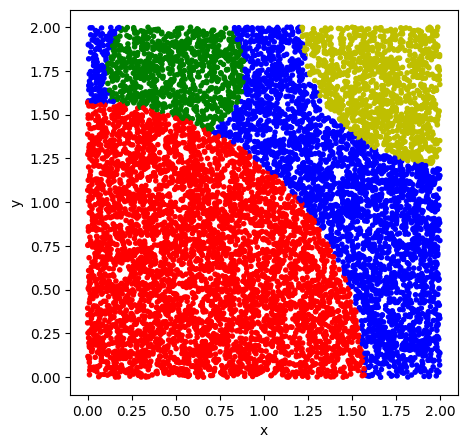

In [4]:
#| label: fig-data
#| fig-cap: "Data to be classified"
#| code-fold: false

visual = [get_random_point() for _ in range(10000)]
visual = [(dp[0],dp[1],calculate_label(dp)) for dp in visual]

test_data =[get_random_point() for _ in range(1000)]

training_data = [get_random_point() for _ in range(250)]
labels = [calculate_label(dp) for dp in training_data]

visualize_points(visual)

## 3.2 Measurement and interpretation

Before looking at our Ansatz, we will first look at what we do with the final state. When we insert a data point in the circuit, we will find some final state, which we now need to measure, to infer the classification result. The circuit prepares a state $|\phi\rangle = c_0 |0\rangle + c_1 |1\rangle$. If we simply measure in the computational basis, we have the result $|0\rangle$ with a probability of $p_0=|c_0|^2$ and the result $|1\rangle$ with probability $p_1=|c_1|^2$.

For more information, we need to prepare the final state several times in order to measure the expectation value of some observable. The simplest case would be to measure the observable $\Lambda = |1\rangle\langle 1| =  \begin{pmatrix}
0 & 0\\
0 & 1
\end{pmatrix}$, where we would receive
$$\langle \Lambda \rangle = \langle \phi |\Lambda| \phi \rangle = \langle \phi | 1\rangle\langle 1|\phi \rangle =  c_1^* c_1 = |c_1|^2 =  p_1$$
which lets us classify based on the probabilities. Binary data with only two classes $0$ and $1$ can be labeled in a straightforward manner: If $p_1 < 0.5$ we choose class $0$, otherwise we assign the label $1$. For our more general case with four classes, we have several different ways we could assign labels:

### Several thresholds

We can directly generalize the way we classify by adding more divisions of $p_1$. $p_1$ takes values in $[0,1]$. If we divide this interval into $n$ different sections, we have a way of distinguishing $n$ classes. We can interpret this on the Bloch sphere as making parallel slices of the sphere so that we get $n$ bands. We than classify based on the band the state is on.


### Assignment using Projectors
One interpretation of the binary classification, would be to think of $p_1$ as the fidelity between $|1\rangle$ and $|\phi\rangle$. This would mean, that we choose label $1$ if the fidelity between $|1\rangle$ and $|\phi\rangle$ is bigger than between $|0\rangle$ and $|\phi\rangle$. This allows for a different kind of generalization: We determine $n$ different states  $|\psi_i\rangle$ as the representatives of $n$ different classes. We then calculate the fidelity between the output of the circuit with all of these $n$ label states and assign the label that is closest to the output, i.e. the one with the highest fidelity. We can compute these fidelities by calculating the expectation value of the projector onto the label states $\Lambda_i = |\psi_i\rangle\langle\psi_i|$, which would be
$$
\langle\Lambda_i\rangle = \langle \phi |\psi_i\rangle\langle\psi_i| \phi \rangle = \langle \psi_i |\phi\rangle^*\langle\psi_i| \phi \rangle = |\langle\psi_i| \phi \rangle|^2.
$$
The $i$ for which this value is maximal will be the label for $| \phi \rangle$. We will use this method to assign labels using the trained circuit. We still need to examine how we choose these label states. The criterion for these should be, that they are as far apart as possible. One way to specify that would be to find states such that $min_{i,j} |\langle\psi_i|\psi_j \rangle |^2$ is as big as possible. In terms of the Bloch Sphere we search $n$ points on the sphere that have the highest pairwise distance. For 4,6,8,12 and 20 classes it is fairly intuitive that we get these label states as the vertices of the respective regular polyhedron. For all other amounts this is a harder question to answer. For 4 classes the label states can be seen in (@fig-states).

In [5]:
#| code-fold: false
def get_label_state(n):
    if n == 0:
        return tq.QubitWaveFunction.from_array([1,0])
    if n == 1:
        return tq.QubitWaveFunction.from_array([1 / np.sqrt(3), np.sqrt(2/3)])
    if n == 2:
        return tq.QubitWaveFunction.from_array([1 / np.sqrt(3),np.exp(1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
    if n == 3:
        return tq.QubitWaveFunction.from_array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
    pass

In [6]:
#| code-fold: false
def fidelity(circuit, label_state):
    """

    :param circuit: The quantum circuit
    :param label_state: The wave function of the label state
    :return: The expectation value of the projector onto func in the state prepared by circuit
    """
    projector = tq.paulis.Projector(wfn=label_state)
    objective = tq.ExpectationValue(circuit, projector)
    return objective

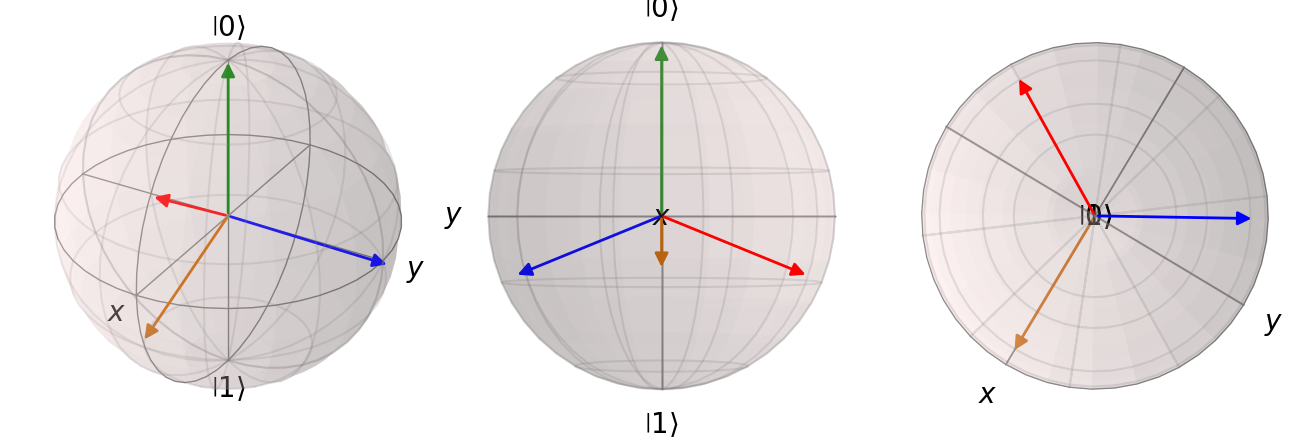

In [7]:
#| label: fig-states
#| fig-cap: "Label states for 4 classes from several angles"
#| fig-format: png
def show_label_states():
    x1 = qutip.Qobj(tq.QubitWaveFunction.to_array(get_label_state(0)))
    x2 = qutip.Qobj(tq.QubitWaveFunction.to_array(get_label_state(1)))
    x3 = qutip.Qobj(tq.QubitWaveFunction.to_array(get_label_state(2)))
    x4 = qutip.Qobj(tq.QubitWaveFunction.to_array(get_label_state(3)))

    fig = plt.figure(figsize=(13,12), layout='constrained')
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax1.set_title("label states")
    ax2 = fig.add_subplot(1,3,2, projection='3d')
    ax2.set_title("Real part")
    ax2.azim = 90
    ax2.elev = 0
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    ax3.set_title("Top down view")
    ax3.elev = 90

    b = qutip.Bloch(fig=fig, axes=ax1)
    b.vector_width = 2
    b.add_states([x1,x2,x3,x4])
    b.render()

    b2 = qutip.Bloch(fig=fig, axes=ax2)
    b2.vector_width = 2
    b2.add_states([x1,x2,x3,x4])
    b2.render()

    b3 = qutip.Bloch(fig=fig, axes=ax3)
    b3.vector_width = 2
    b3.add_states([x1,x2,x3,x4])
    b3.render()

show_label_states()


### Assignment using the full state
In the previous solution, we needed one measurement of an expectation value for each class. For a circuit with only one qubit, this seems unreasonably high, as the full state is only characterized by two real numbers and given the full state we could easily calculate the fidelities with all label states. So we might be able to get rid of the scaling number of calculated expectation values if we are able to just calculate the full state with a constant number of expectation values. This is indeed possible using a state tomography protocol, which allows us to obtain the full state with only three expectation values for a single qubit [@Schmied_2016]. We can visualize the information we gain from a single expectation value using the Bloch sphere. For this we look at the state $|-i\rangle$ and the three pojectors $|0\rangle\langle 0|$, $|+\rangle\langle +|$,$|i\rangle\langle i|$. Assuming we don't know that the sytem is in state $|-i\rangle$, we will figure this out using the three expectation values of the projectors. The expectation value of $|0\rangle\langle 0|$ will have the result $0.5$, which gives us the information that the state has to be on the ring seen in @fig-tom. $\langle (|+\rangle\langle +|)\rangle$ will also be $0.5$, so that we are now restricted to two possible states, the ones where both rings intersect in @fig-tom. After the final measurement we will now be able to fully determine the final state of the system. This works for all one-qubit states.

Theoretically this an also be done for more qubits, but requires an exponential amount of expectation values, as the dimensionality of the state also grows exponentially.


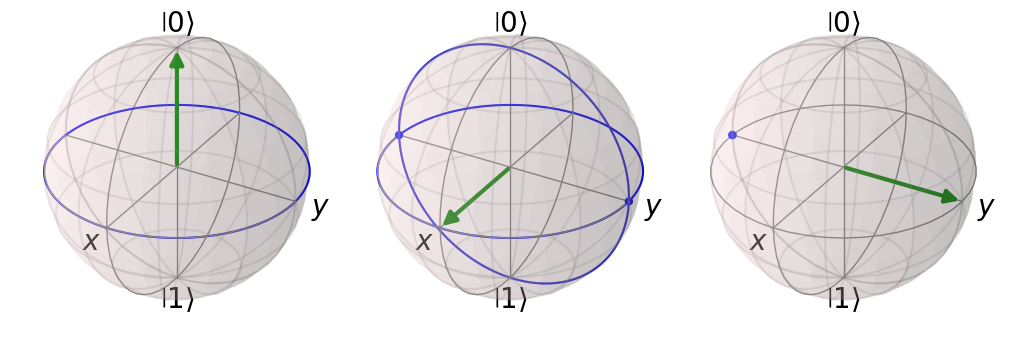

In [8]:
#| label: fig-tom
#| fig-cap: "Possible states after one, two and three measurements. The arrow describes the projector we are measuring"
def add_line(bloch, x,y):
    bloch.add_arc(x, y)
    bloch.add_arc(-x, y)
    bloch.add_arc(x, -y)
    bloch.add_arc(-y, -x)

def tomography():
    fig = plt.figure(figsize=(10,10), layout='constrained')
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2, projection='3d')
    ax3 = fig.add_subplot(1,3,3, projection='3d')

    b1 = qutip.Bloch(fig=fig, axes=ax1)
    b2 = qutip.Bloch(fig=fig, axes=ax2)
    b3 = qutip.Bloch(fig=fig, axes=ax3)
    X = np.arange(-1, 1, 0.1)
    Y = np.arange(-1, 1, 0.1)
    Z = np.ones((20,20))

    b1.add_vectors([0,0,1])
    add_line(b1, np.array([1,0,0]), np.array([0,1,0]))
    ax1.plot_surface(X, Y, Z)
    b2.add_vectors([1,0,0])
    add_line(b2, np.array([1,0,0]), np.array([0,1,0]))
    add_line(b2, np.array([0,1,0]), np.array([0,0,1]))
    b2.add_points([[0,0],[1,-1],[0,0]])

    b3.add_vectors([0,1,0])
    b3.add_points([0,-1,0])

    b1.render()
    b2.render()
    b3.render()
    plt.show()

tomography()


## 3.3 Ansatz

After figuring out how we turn the final state into a classification result, we can look at the circuit that prepares the final state. We need to build a parameterized circuit, that allows us to insert a datapoint $x$ and parameters $\theta$. We will be limited to gates that operate on one qubit, so our main choices are rotations $R_x,R_y,R_z$. Using only rotations, it would be impossible to separate the data nonlinearly if we inserted the datapoint only once. We need a layered structure, where each layer inserts the datapoint and some of the parameters.
The entire circuit has the form
$$
U(\theta,x) = L(N)...L(1)
$$
where $N$ is the amount of layers in our circuit. One layer is then composed of several rotations
$$
L(i)= R_z(\theta_{2i+1}+x_2) R_y(\theta_{2i} + x_1)
$$
using a set of $2N$ angles $\theta$ and the datapoint $x=(x_1,x_2)$. The amount of layers determines the depth of our circuit, as we apply two gates per layer. Also, the amount of computation needed increases as we introduce more layers, as we get two parameters for each layer.

Why did we choose the setup with one $R_z$ and $R_y$ gate? This choice was to a certain level arbitrary.  We chose two gates as we use data from $\mathbb{R}^2$, where every gate encodes one of the two values. The choice for the type of gates was made, so that it is possible to rotate every state to every other state. Any combination of two different rotations would be satisfactory, so this choice was arbitrary.

We could adapt the layers to encode more parameters, by introducing weights $w$ for every insertion of the datapoint. One layer would then look like
$$
L(i)= R_z(\theta_{2i+1}+w_{2i+1} x_2) R_y(\theta_{2i} + w_{2i}x_1).
$$
In theory this increases the expressiveness of the circuit. If we replaced the unweighted layers with their weighted alternatives, we only need to set all weights to 1 and would receive the same result as the unweighted case.  The computation will be more expensive, but the final result should always be as good as for the unweighted case or even better. We will see if this assumption holds true in section 4.

In [9]:
#| code-fold: false
def create_circuit(x, angles):
    circuit = tq.QCircuit()
    for i in range(len(angles) // 2):
        circuit += tq.gates.Ry(angles[2*i] + x[0],0) + tq.gates.Rz(angles[2*i+1] + x[1],0)
    return circuit

## 3.4 Loss function

Now we have everything required to calculate a label for a datapoint and will now examine how we determine the correctness of this assignment. This is done through the loss function. Given a set of values for the parameters in the circuit and the training data, the loss function evaluates how close the result of the circuit is to the actual labels. One possible function is
$$
\lambda(X,\theta) = \frac{1}{|X|}\sum_{x\in X} (1-|\langle \psi_c(x)| U(\theta,x)|0\rangle|^2)^2
$$
where $| \psi_c(x)\rangle$ is the label state of the class that $x$ belongs to and $X$ is the training data. Each element of the sum is one minus the fidelity between the circuit result and the correct label, therefore each element takes values in $[0,1]$. If for one $x$ it is $0$, that means the fidelity between the correct label and the circuit result is $1$, so the circuit has transformed $x$ in the correct state. Alternatively, if the fidelity is low, this datapoint would contribute a fairly big amount to the loss function. In the optimal case, that everything gets classified correctly, the value of the loss function would be zero. In order to get a proper classifier, all that is needed now, is the values of $\theta$ such that $\lambda$ is minimal. We try to find these values in the optimization step in the next section.

For the optimization it is useful to rewrite $\lambda$. Instead of looking at fidelities between states, we express the loss in terms of expectation values
$$
\lambda(X,\theta) = \frac{1}{|X|}\sum_{x\in X} (1-\langle 0|U(\theta,x)^T \Psi_c(x) U(\theta,x)|0\rangle)^2
$$
where $\Psi_c(x) = | \psi_c(x)\rangle \langle \psi_c(x)|$ is the projector defined by the correct label state of $x\in X$. This is also the way it is implemented.

In [10]:
#| code-fold: false

def cost(train_set, labels, parameters, circuit):
    """

    :param train_set: A list of the datapoints in the training set
    :param labels: A list of the labels of the datapoints
    :param parameters: The values of the parameters in the parameterized circuit
    :param circuit: A function that returns a circuit and takes one datapoint and
                    the parameters as arguments
    :return: The value of the loss function
    """
    loss = 0.0
    for i in range(len(train_set)):                             #<1>
        qc = circuit(train_set[i],parameters)
        target = get_label_state(labels[i])
        fid = fidelity(qc, target)                      #<2>
        loss = loss + ((1-fid) ** 2)                    #<3>
    return loss / len(train_set)

1. We iterate through the training data and calculate the impact of that datapoint on the loss function
2. The fidelity between the circuit result and the correct label state is expressed as a expectation value
3. A value in $[0,1]$ gets added based on how good the current datapoint is treated by the circuit

## 3.5 Minimization

The training requires us to find values of the tunable parameters $\theta$ such that the loss function  $\lambda(X,\theta)$ is minimal. There are many different methods with different advantages and properties to solve optimization problems. Many of these optimization algorithms have a local approach for minimization, meaning we iteratively calculate values $\theta_0,\theta_1,...,\theta_n$ where we calculate $\theta_i$ based on some calculation using $\theta_{i-1}$. For most algorithms, we compute or approximate the gradient $\nabla \lambda(X,\theta_{i-1})$ or the hessian $H \lambda(X,\theta_{i-1})$ in order to calculate $\theta_{i}$. The gradient is the vector of the first derivatives and the hessian is the matrix containing all second derivatives. The calculation of these values is fairly expensive and explains why they are in many cases only approximated.

We can view our loss function as a function of expectation values, which are in turn functions of the parameters and a single datapoint. This means for the calculation of the gradient we can split the function using the chain rule:
$$
\frac{\partial \lambda(X,\theta)}{\partial\theta} = \sum_{x\in X}\frac{\partial \lambda(X,\theta)}{\partial \langle E_x\rangle} \frac{\partial \langle E_x\rangle}{\partial\theta}
$$
where $\langle E_x\rangle = \langle 0|U(\theta,x)^T \Psi_c(x) U(\theta,x)|0\rangle$. This way we get two parts that we can examine separately. The left part can be done through automatic differentiation like it is usually done for differentiation problems. The right part concerns the differentiation of a quantum circuit with respect to one of the parameters, for which there are several methods, two of these are numerical differentiation and the parameter shift rule [@crooks2019gradients]. Using the result of these calculations, we now have the gradient to determine the next step in an iteration of the optimization.

Without further examining whether our choice theoretically leads to a good result, we will be choosing ```BFGS``` as our optimization algorithm as used in [@PerezSalinas2020datareuploading].

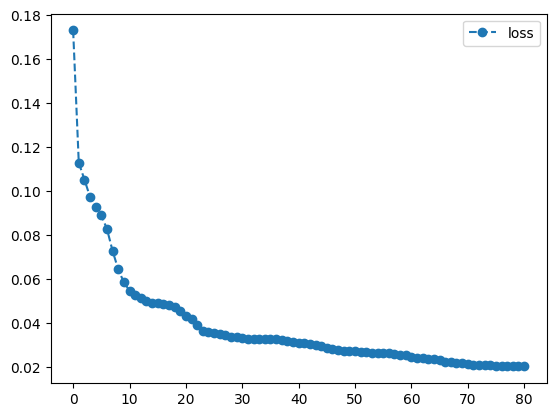

None


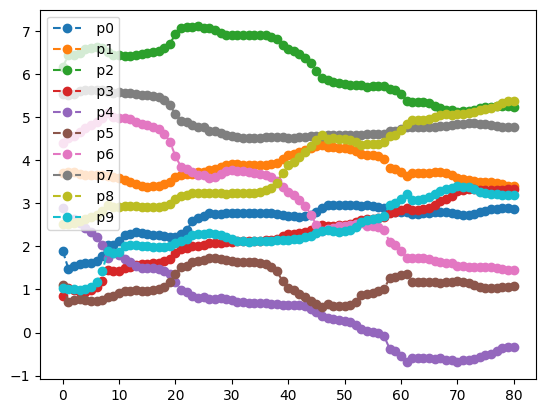

None


In [11]:
#| code-fold: false
#| output: true
layers = 5
param_unweighted = [tq.Variable('p' + str(i)) for i in range(layers * 2)]
initials_unweighted = {key: random.uniform(0, 2 * np.pi) for key in param_unweighted}



Objective1 = cost(training_data, labels, param_unweighted, create_circuit)

result1 = tq.minimize(objective=Objective1, initial_values=initials_unweighted,  silent=True, backend="qulacs")
print(result1.history.plot('energies', label='loss'))
print(result1.history.plot('angles', label=""))

## 3.6 Results

We have done the optimization and have the optimal parameter assignment stored in ```result1.angles```. With these results we can run through our test set and assign the labels according to the method from section 3.2. For this, we calculate the fidelity to the different label states and assign the label with the highest fidelity. We can use the visualization we used earlier for @fig-data to compare the correct labels with the trained circuit. By computing the correct label through ```calculate_label()```, we can also calculate the percentage of correct guesses. As a reference, guessing randomly would give us a success rate of $0.25$.

Success Rate:  0.877


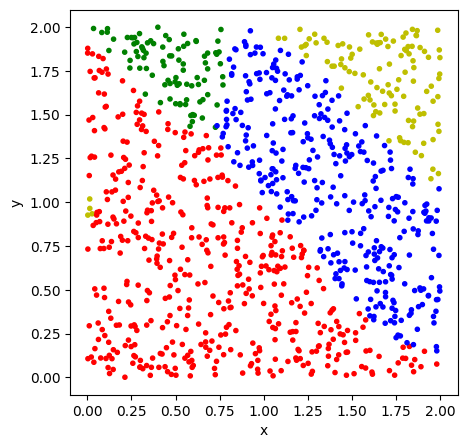

In [12]:
#| code-fold: false

def assign_label(datapoint, opt_params, circuit, param):
    qc = circuit(datapoint,param)
    max_fid = 0
    choice = 0
    for i in range(4):
        H = tq.paulis.Projector(get_label_state(i))
        Exp = tq.ExpectationValue(U=qc, H=H)
        fid = tq.simulate(Exp, variables=opt_params)
        if fid > max_fid:
            max_fid = fid
            choice = i
    return choice

def test_and_visualize(testing_data, opt_params, circuit, param):
    labeled_set = []
    num_correct = 0
    for x in testing_data:
        label = assign_label(x, opt_params, circuit, param)
        if label == calculate_label(x):
            num_correct += 1
        labeled_set.append((x[0], x[1], label))

    print("Success Rate: ", num_correct / len(testing_data))
    visualize_points(labeled_set)

test_and_visualize(test_data, result1.angles, create_circuit, param_unweighted)

As we can see, the circuit has learned the data fairly well, leading to a success rate of $88\%$ using 5 layers. In comparison to other machine learning algorithms like neural networks, this result holds up well, as we are only using 10 parameters in our circuit, and are still able to perform fairly well. For many other systems the amount of required parameters would rise significantly faster.

# 4 Weighted circuit

Now that we have seen a full example for a Variational Quantum Algorithm used to classify data, we can try to adapt certain parts of it, to see what impact some changes can have. We had already described, how  we could add weights for the insertion of a datapoint. This change will only affect the circuit, while everything else stays the same in order to have a direct comparison.

In [13]:
#| code-fold: false
def create_weighted_circuit(x, parameters):
    circuit = tq.QCircuit()
    for i in range(len(parameters) // 4):
        circuit += tq.gates.Ry(parameters[4*i] + (parameters[4*i+1]  * x[0]),0) + tq.gates.Rz(parameters[4*i+2] + (parameters[4*i+3] * x[1]),0)
    return circuit


We can see that every layer now uses 4 parameters. Because we keep the amount of layers the same, we need to optimize twice as many parameters, which will increase the needed computation. We are able to use the previous result as our initial guess in order to start at a decent value. If we assign the value $1$ to all newly introduced weights and use the optimization result for all other parameters, we now start with exactly the same circuit as we finished on the previous optimization, but we now have many new parameters that can be further optimized.

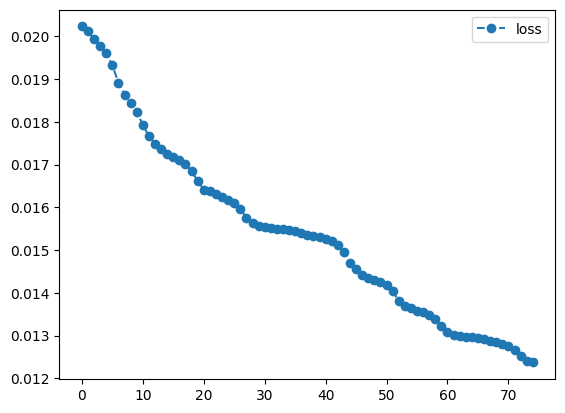

None


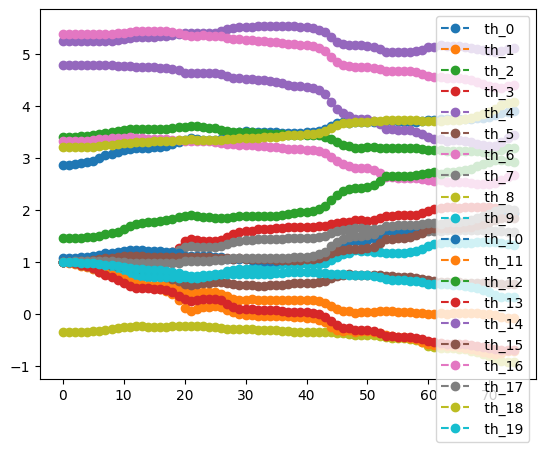

None


In [16]:
#| code-fold: false
param_weighted = [tq.Variable('th_' + str(i)) for i in range(layers * 4)]

#initialize the variables so that we start out with the optimized circuit from the first optimization
initials_weighted = {}
for i in range(len(param_weighted)):
    if i % 2 == 0:
        initials_weighted[param_weighted[i]] = result1.angles[('p' + str(i//2))]
    else:
        initials_weighted[param_weighted[i]] = 1

Objective2 = cost(training_data, labels, param_weighted, create_weighted_circuit)

result2 = tq.minimize(objective=Objective2,variables=param_weighted, initial_values=initials_weighted, maxiter=150,  silent=True, backend="qulacs")

print(result2.history.plot('energies', label='loss'))
print(result2.history.plot('angles', label=""))

Success Rate:  0.936


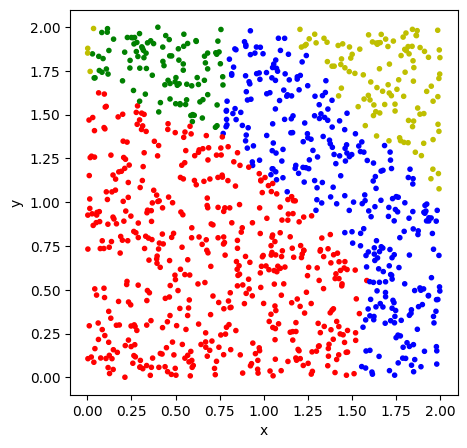

In [17]:
#|code-fold: false
test_and_visualize(test_data, result2.angles, create_weighted_circuit, param_weighted)

As we can see, our first result has been increased by a slight margin. Sadly, we don't have options to check if there are any better solutions, as our used method only converges to a local minimum. The first optimization already determined the rough area we will be able to examine, the second iteration was only able to find a deepest valley in the already determined region. With a different result for our first round, we might have ended up with a way better or worse result, but we would need to run the entire process several times in order to increase our chances for finding a very good solution.

# 5 Final remarks

We have seen how to build a Variational Quantum Algorithm to classify data from four different classes using only one qubit in the quantum circuit. The circuit was built out of layers of unitary transformations, where each layer introduces the datapoint and two new parameters. Using this setup, we minimized the loss function, which was based on the fidelity of the result of the circuit and the label state of the correct class. The resulting circuit was able to mostly succeed in classifying the test data. We then increased the amount of parameters in the circuit, which lead to even further improvement of the classification. While this result is promising, this is not really a result that has a lot of practical use, as we are only using one qubit and probably should consider a circuit with more qubits, as one of the main strengths in quantum computing comes from the ability to entangle the qubits and use the structures formed with many qubits to gain computational advantage over classical computers. Nevertheless, this example shows that even a single qubit is able to solve a classification task using a variational approach.

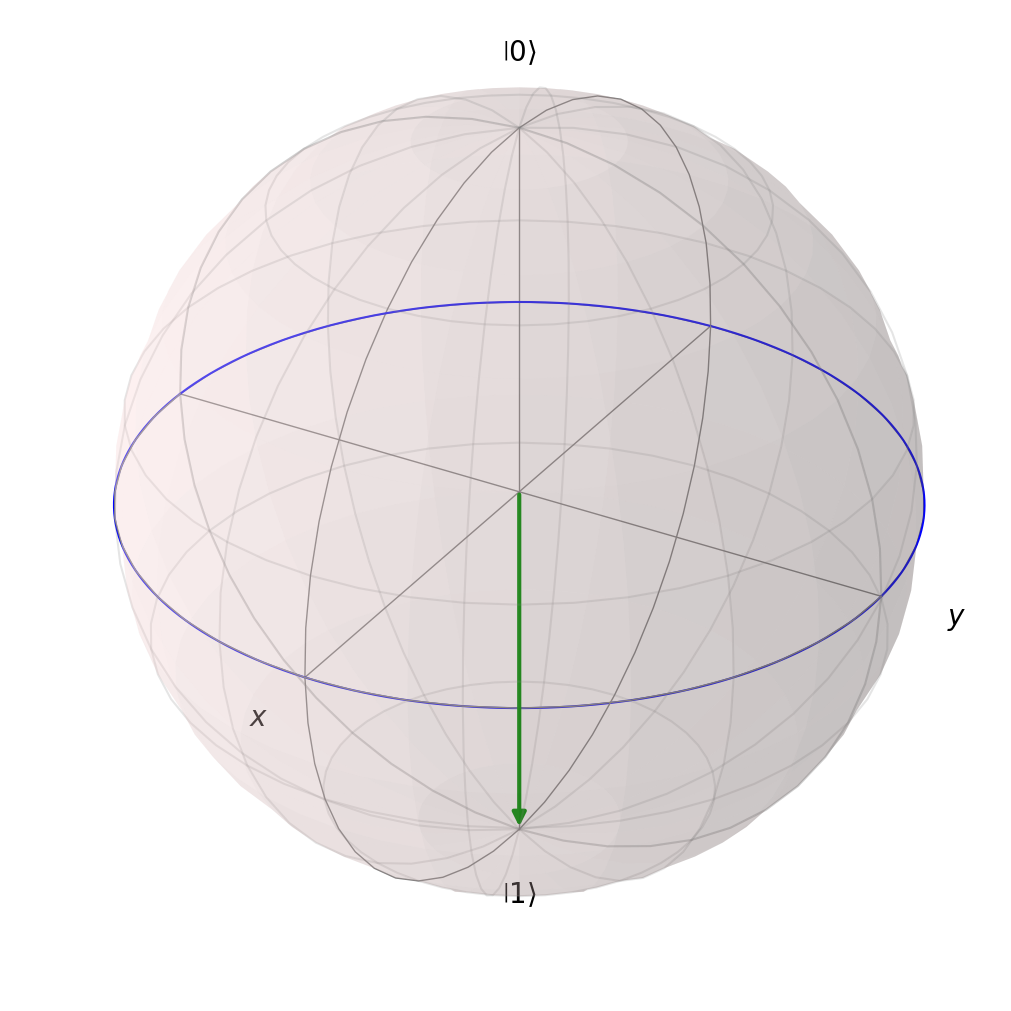

In [11]:
fig = plt.figure(figsize=(10,10), layout='constrained')
ax1 = fig.add_subplot(1,1,1, projection='3d')
b1 = qutip.Bloch(fig=fig, axes=ax1)
b1.add_vectors([0,0,-1])
add_line(b1, np.array([1,0,0]), np.array([0,1,0]))
b1.render()

---
nocite: |
  @PerezSalinas2020datareuploading, @JOHANSSON20131234, @Kottmann_2021, @Hunter:2007, @Cerezo_2021
---

# 6 Sources

::: {#refs}
:::